In [1]:
# Activate project enviroment 
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\Herbert\Documents\GitHub\AMO_Indivdiual_Project`


In [2]:
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots

## Generation Expansion
In the notebook, we model the following Generation Expansion Problems:

- A deterministic single-node static GEP
- A deterministic single-node dynamic GEP
- A deterministic network-constrained static GEP

As a basis for all Models the 24-bus IEEE Reliability Test System is used (See table below). 
To model the annual energy demand levels of the target year, historical power consumption data from Germany 2022 is used to compute four power level options with respective weights (See Clustering.ipynb). Wind power in all models is considered fixed.
All data for the candidate generators is made up.

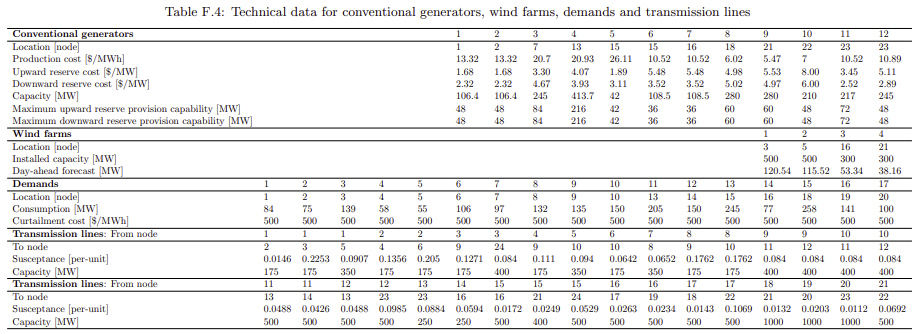

In [3]:
display("image/png", read("./data/Model_table.PNG"))

In [4]:
#Read in demand options for target year (Output of Clustering.ipynb) and sort by powerlevel (ascending)
options = sort!(CSV.read("./data/options.csv", DataFrame),:powerlevel)

Row,powerlevel,weight
,Float64,Float64
1,0.77741,0.244064
2,0.932355,0.280023
3,1.09936,0.313242
4,1.25909,0.162671


## Deterministic single-node static GEP

In [24]:
# Indexes
G = 1:12 # Existing generators
C = 1:5 # Candidate generators
D = 1:1 # Demands (sum of all Loads, because single node Model)
O = 1:4 # Options
Q = 1:7 # Number of steps for installable capacity. (Same for each candidate)

# Parameters
ic = [600_000, 700_000, 400_000, 1_200_000, 950_000].*0.03 #Annulized Investment cost per installed MW for each candidate
pd = sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) .* options.powerlevel # demand for each option
Emax = [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245] # existing generator maximium capacity
Ec = [13.32,13.32,20.7,20.93,26.11,10.52,10.52,6.02,5.47,7,10.52,10.89] # existing Generator Energy cost
CandiData = [0.0 30.0 60.0 90.0 120.0 150.0 180.0  # Possible Capacity installation levels for each candidate
             0.0 30.0 60.0 90.0 120.0 150.0 180.0
             0.0 40.0 80.0 120.0 160.0 200.0 240.0
             0.0 40.0 80.0 120.0 160.0 200.0 240.0
             0.0 50.0 100.0 150.0 200.0 250.0 300.0]
Cc = [11.7,10.4,13.2,8.7,9.5] # operating cost per MW for candidates
vLOL = 500 # value of lost load
wp = sum([120.54,115.52,53.34,38.16]) # wind power (no cost)

ρ = Integer.(round.(options.weight .* 8760)) # = [2744,1425,2453,2138] -> hours in a year for each operating condition

M = 1_000_000 # Big M 

# one last thing - we consider the demands as historical data, but demand in the future will grow. So, we will increase the demand options by a percentage for each year.
# Our planning horzion is 20 years. To get realistic average annual increase in demand,
# we use historical data of the yearly demand from 2015 to 2018 in Germany source: https://www.smard.de/home/downloadcenter/download-marktdaten/.

yearly_demands = [500219502.50, 503083631.75, 505674706.50 ,509156603.75] 
annual_increase = mean([yearly_demands[i+1]/yearly_demands[i] for i in 1:3]) # calculate the mean of the relative annual changes from 2015-2018
twenty_year_increase = annual_increase^20
pd = round.(pd.*twenty_year_increase,digits = 1) # multiply by expected increase factor of 20 years.


4-element Vector{Float64}:
 1930.8
 2315.6
 2730.3
 3127.0

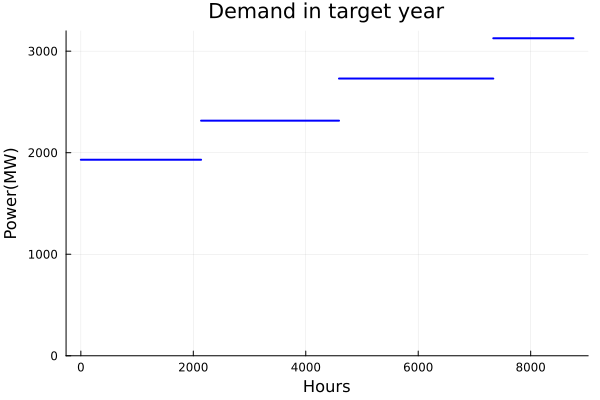

In [25]:
#lets take a look at the powerlevels and their amount of hours in the year
plot([0;ρ[1]],[pd[1];pd[1]],legend = false, lc = :blue,lw=2,ylims=(0,:3200),xlabel="Hours",ylabel="Power(MW)",title="Demand in target year")
plot!([ρ[1];sum(ρ[1:2])],[pd[2];pd[2]],lc=:blue,lw=2)
plot!([sum(ρ[1:2]);sum(ρ[1:3])],[pd[3];pd[3]],lc=:blue,lw=2)
plot!([sum(ρ[1:3]);sum(ρ[1:4])],[pd[4];pd[4]],lc=:blue,lw=2)

In [26]:
#Building the MILP Model (as explained in "Investment in Electricity Generation and Transmission", Conejo et al, Chapter 3.3.3)

gep1 = Model(HiGHS.Optimizer)
set_silent(gep1)

@variables(gep1, begin
        pge[g in G, o in O] >= 0
        pgc[c in C,o in O] >= 0
        pcmax[c in C] >= 0
        λ[o in O] >= 0
        uOp[c in C, q in Q], Bin
        μ_emax[g in G, o in O] >= 0
        μ_cmax[c in C, o in O] >= 0
        zaux[c in C,q in Q, o in O]
        zaux2[c in C, q in Q, o in O]
        Lshed[o in O] >= 0
end)

@constraint(gep1, EQ7B[c in C], pcmax[c] == sum(uOp[c,q]*CandiData[c,q] for q in Q))

@constraint(gep1, EQ7C[c in C], sum(uOp[c,:]) == 1)

@constraint(gep1, EQ7E[o in O], sum(pge[g,o] for g in G) + sum(pgc[c,o] for c in C) + wp + Lshed[o] == pd[o])

@constraint(gep1,EQ7F[g in G, o in O], pge[g,o] <= Emax[g])

@constraint(gep1, EQ7G[c in C, o in O],pgc[c,o] <= pcmax[c])

@constraint(gep1, EQ7H[g in G, o in O], Ec[g] - λ[o] + μ_emax[g,o] >= 0)

@constraint(gep1, EQ7I[c in C, o in O], Cc[c] - λ[o] + μ_cmax[c,o] >= 0)

@constraint(gep1, EQ7L[o in O], sum(Ec[g] * pge[g,o] for g in G) + sum(Cc[c] * pgc[c,o] for c in C) ==
                λ[o] * pd[o] - sum(μ_emax[g,o] * Emax[g] for g in G) - sum(sum(zaux[c,q,o] for q in Q) for c in C ))

@constraint(gep1, EQ7M[c in C, q in Q, o in O], zaux[c,q,o] == μ_cmax[c,o]* CandiData[c,q] - zaux2[c,q,o])

@constraint(gep1, EQ7Na[c in C, q in Q, o in O], 0 <= zaux[c,q,o])

@constraint(gep1, EQ7Nb[c in C, q in Q, o in O], zaux[c,q,o] <= uOp[c,q] * M)

@constraint(gep1, EQ7Oa[c in C, q in Q, o in O], 0 <= zaux2[c,q,o])

@constraint(gep1, EQ7Ob[c in C, q in Q, o in O], zaux2[c,q,o] <= (1-uOp[c,q]) * M)

@objective(gep1, Min, sum(ρ[o] * (sum(Ec[g]* pge[g,o] for g in G) + sum(Cc[c]*pgc[c,o] for c in C) + vLOL*Lshed[o]) for o in O) + sum(ic[c] * pcmax[c] for c in C) )

#print(gep1)

28478.16 pge[1,1] + 28478.16 pge[2,1] + 44256.6 pge[3,1] + 44748.34 pge[4,1] + 55823.18 pge[5,1] + 22491.76 pge[6,1] + 22491.76 pge[7,1] + 12870.759999999998 pge[8,1] + 11694.859999999999 pge[9,1] + 14966 pge[10,1] + 22491.76 pge[11,1] + 23282.82 pge[12,1] + 25014.6 pgc[1,1] + 22235.2 pgc[2,1] + 28221.6 pgc[3,1] + 18600.6 pgc[4,1] + 20311 pgc[5,1] + 1069000 Lshed[1] + 32673.96 pge[1,2] + 32673.96 pge[2,2] + 50777.1 pge[3,2] + 51341.29 pge[4,2] + 64047.83 pge[5,2] + 25805.559999999998 pge[6,2] + 25805.559999999998 pge[7,2] + 14767.06 pge[8,2] + 13417.91 pge[9,2] + 17171 pge[10,2] + 25805.559999999998 pge[11,2] + 26713.170000000002 pge[12,2] + 28700.1 pgc[1,2] + 25511.2 pgc[2,2] + 32379.6 pgc[3,2] + 21341.1 pgc[4,2] + 23303.5 pgc[5,2] + 1226500 Lshed[2] + 36550.08 pge[1,3] + 36550.08 pge[2,3] + 56800.799999999996 pge[3,3] + 57431.92 pge[4,3] + 71645.84 pge[5,3] + 28866.879999999997 pge[6,3] + 28866.879999999997 pge[7,3] + 16518.879999999997 pge[8,3] + 15009.679999999998 pge[9,3] + 19208 

In [27]:
optimize!(gep1)
termination_status(gep1)

OPTIMAL::TerminationStatusCode = 1

In [31]:
value.(pge)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:12
    Dimension 2, 1:4
And data, a 12×4 Matrix{Float64}:
   0.0     0.0    97.34  106.4
   0.0     0.0   106.4   106.4
   0.0     0.0     0.0   245.0
   0.0     0.0     0.0   142.64
   0.0     0.0     0.0     0.0
   0.0   108.5   108.5   108.5
   0.0   108.5   108.5   108.5
 280.0   280.0   280.0   280.0
 280.0   280.0   280.0   280.0
 210.0   210.0   210.0   210.0
 113.24  217.0   217.0   217.0
   0.0    64.04  245.0   245.0

In [32]:
value.(pgc)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:5
    Dimension 2, 1:4
And data, a 5×4 Matrix{Float64}:
   0.0    0.0   30.0   30.0
 180.0  180.0  180.0  180.0
   0.0    0.0   -0.0   -0.0
 240.0  240.0  240.0  240.0
 300.0  300.0  300.0  300.0

In [33]:
value.(pcmax)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:5
And data, a 5-element Vector{Float64}:
  30.0
 180.0
   0.0
 240.0
 300.0

In [12]:
value.(uOp)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:5
    Dimension 2, 1:7
And data, a 5×7 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [13]:
value.(λ)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{Float64}:
  7.087254307374226
  8.00030771221532
 10.047188210088944
 13.458987462170343